In [24]:
from Historic_Crypto import HistoricalData as HD
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import scipy


# Argument ---	   Description
- ticker ---	       supply the ticker information which you want to return (str).
- granularity ---	   please supply a granularity in seconds (60, 300, 900, 3600, 21600, 86400) (int).
- start_date ---	   a string in the format YYYY-MM-DD-HH-MM (str).
- end_date ---	   a string in the format YYYY-MM-DD-HH-MM (str). Optional, Default: Now
- verbose ---	       printing during extraction. Default: True

In [91]:
def etherScanAPICall(wallet_address):
    API_KEY = 'JATAZ8XWIBGBTY15YJJEABCDPIF8SCK7S3'
    MATIC_CONTRACT_ADDRESS = '0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0'
    # WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
    url = 'https://api.etherscan.io/api?'

    parameters = {
        'module':'account',
        'action':'tokentx',
        'contractaddress':MATIC_CONTRACT_ADDRESS,
        'address':wallet_address,
        'page':'1',
        'offset':'10000',
        'startblock':'0',
        'endblock':'27025780',
        'sort':'asc',
        'apikey':API_KEY
    }

    responseJSON = requests.request("GET", url, params=parameters).json()

    with open("response.json", "w") as write_file:
        json.dump(responseJSON, write_file, indent=4, sort_keys = True)

    return responseJSON


In [92]:
def convert_UNIX_to_DateTime(unix):
    return datetime.utcfromtimestamp(int(unix)).strftime('%Y-%m-%d %H:%M:%S') # returns type str

In [93]:
def getDailyTransactionVolume(transactionData):
    dailyTransactionVolume = {}

    for transaction in transactionData.get('result'):
        timeStamp = convert_UNIX_to_DateTime(transaction.get("timeStamp"))
        timeStamp = timeStamp[0:10]
        if (timeStamp in dailyTransactionVolume):
            cnt = dailyTransactionVolume.get(timeStamp) + 1
            dailyTransactionVolume[timeStamp] = cnt
        else:
            dailyTransactionVolume[timeStamp] = 1

    return dailyTransactionVolume

In [141]:
# WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
rawTransactionData = etherScanAPICall('0x9507c04b10486547584c37bcbd931b2a4fee9a41')

# rawTransactionData = etherScanAPICall('0x5666ed92c83af9dab61601c87bf7769ad57103f9')

rawDailyTransactionVolume = getDailyTransactionVolume(rawTransactionData)

# del rawDailyTransactionVolume['2022-08-24']

print(len(rawDailyTransactionVolume))
print(rawDailyTransactionVolume)

59
{'2022-08-24': 2, '2022-09-23': 69, '2022-09-24': 48, '2022-09-25': 40, '2022-09-26': 96, '2022-09-27': 34, '2022-09-28': 3, '2022-09-29': 19, '2022-09-30': 103, '2022-10-01': 9, '2022-10-02': 26, '2022-10-03': 60, '2022-10-04': 69, '2022-10-05': 4, '2022-10-07': 3, '2022-10-08': 27, '2022-10-10': 1, '2022-10-12': 2, '2022-10-18': 1, '2022-10-21': 19, '2022-10-22': 24, '2022-10-23': 29, '2022-10-24': 28, '2022-10-25': 63, '2022-10-26': 49, '2022-10-27': 51, '2022-10-28': 46, '2022-10-29': 56, '2022-10-30': 71, '2022-10-31': 44, '2022-11-01': 29, '2022-11-02': 87, '2022-11-03': 116, '2022-11-04': 162, '2022-11-05': 110, '2022-11-06': 73, '2022-11-07': 88, '2022-11-08': 97, '2022-11-11': 37, '2022-11-12': 5, '2022-11-14': 48, '2022-11-15': 13, '2022-11-16': 20, '2022-11-17': 30, '2022-11-18': 2, '2022-11-19': 8, '2022-11-20': 23, '2022-11-21': 1, '2022-11-23': 21, '2022-11-24': 61, '2022-11-25': 34, '2022-11-26': 14, '2022-11-27': 15, '2022-11-28': 7, '2022-11-29': 15, '2022-11-30': 5

In [142]:
def getStartAndEndDate(transactionData):
    startDate = next(iter(transactionData)) 
    endDate = list(transactionData)[-1]
    return [startDate, endDate]

In [143]:
def getCryptoHistoricalData(token, startDate, endDate):
    data = HD(token,86400,startDate+"-00-00",endDate+"-00-00").retrieve_data()
    data.to_csv('dataframe.csv')
    return data

In [144]:
startAndEndDate = getStartAndEndDate(rawDailyTransactionVolume)

rawTokenData = getCryptoHistoricalData('MATIC-USD', startAndEndDate[0], startAndEndDate[1])

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'MATIC-USD' found at the CoinBase Pro API, continuing to extraction.
Retrieved Data from Coinbase Pro API.
Returning data.


In [145]:
def getRangePrices(tokenData):
    highPrices = list(tokenData["high"])
    lowPrices = list(tokenData["low"])
    rangePrices = [a - b for a, b in zip(highPrices, lowPrices)]
     
    dateTimes = tokenData.index.tolist()

    datesToRangePrice = {}
    cnt = 0

    for dateTime in dateTimes:
        datesToRangePrice[str(dateTime)[0:10]] = rangePrices[cnt]
        cnt += 1

    # print(datesToRangePrice)
    return datesToRangePrice

In [146]:
dailyTokenPriceAction = getRangePrices(rawTokenData)

In [147]:
def alignTransactionsToPrice(transactions, prices):

    newTransactions = {}

    for key in prices.keys():
        if (key in transactions):
            newTransactions[key] = transactions.get(key)
        else:
            newTransactions[key] = 0

    # print(len(prices))
    # print(len(transactions))
    # print(len(newTransactions))
    # print(newTransactions)

    return newTransactions

In [148]:
dailyTransactionVolume = alignTransactionsToPrice(rawDailyTransactionVolume, dailyTokenPriceAction)

In [149]:
def alignPriceToTransactions(transactions, prices):

    newRangePrices = {}

    for key in transactions.keys():
        if (key in prices):
            newRangePrices[key] = prices.get(key)

    # print(len(prices))
    # print(len(transactions))
    # print(len(newRangePrices))
    # print(newRangePrices)

    return newRangePrices

In [150]:
dailyTokenPriceAction = alignPriceToTransactions(rawDailyTransactionVolume, dailyTokenPriceAction)

In [151]:
def createPlotFromDict(dict):
    keys = dict.keys()
    values = dict.values()
    # plt.bar(keys, values)
    plt.plot(keys, values)
    # plots bar chart of keys (x) against values (y)

In [152]:
def printDataSet(data):
    print("Data Length:", len(data))
    print(str(data)+"\n")

In [153]:
printDataSet(rawDailyTransactionVolume)
printDataSet(dailyTokenPriceAction)

Data Length: 59
{'2022-08-24': 2, '2022-09-23': 69, '2022-09-24': 48, '2022-09-25': 40, '2022-09-26': 96, '2022-09-27': 34, '2022-09-28': 3, '2022-09-29': 19, '2022-09-30': 103, '2022-10-01': 9, '2022-10-02': 26, '2022-10-03': 60, '2022-10-04': 69, '2022-10-05': 4, '2022-10-07': 3, '2022-10-08': 27, '2022-10-10': 1, '2022-10-12': 2, '2022-10-18': 1, '2022-10-21': 19, '2022-10-22': 24, '2022-10-23': 29, '2022-10-24': 28, '2022-10-25': 63, '2022-10-26': 49, '2022-10-27': 51, '2022-10-28': 46, '2022-10-29': 56, '2022-10-30': 71, '2022-10-31': 44, '2022-11-01': 29, '2022-11-02': 87, '2022-11-03': 116, '2022-11-04': 162, '2022-11-05': 110, '2022-11-06': 73, '2022-11-07': 88, '2022-11-08': 97, '2022-11-11': 37, '2022-11-12': 5, '2022-11-14': 48, '2022-11-15': 13, '2022-11-16': 20, '2022-11-17': 30, '2022-11-18': 2, '2022-11-19': 8, '2022-11-20': 23, '2022-11-21': 1, '2022-11-23': 21, '2022-11-24': 61, '2022-11-25': 34, '2022-11-26': 14, '2022-11-27': 15, '2022-11-28': 7, '2022-11-29': 15, '2

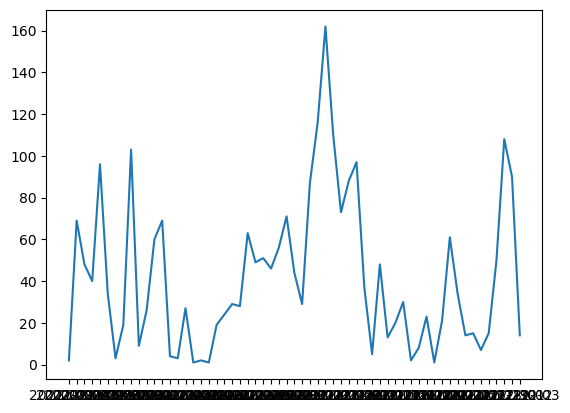

In [154]:
createPlotFromDict(rawDailyTransactionVolume)

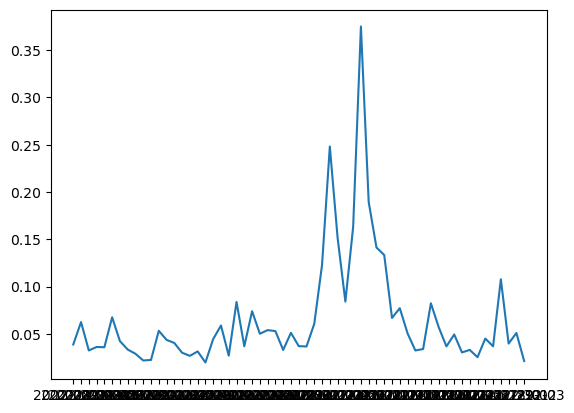

In [155]:
createPlotFromDict(dailyTokenPriceAction)

In [158]:
def performLinearRegression(data1, data2):
    a = list(data1.values())
    b = list(data2.values())

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(a, b)
    
    print("R_value:",r_value**2)
    print("P_value:",p_value)

In [159]:
performLinearRegression(rawDailyTransactionVolume, dailyTokenPriceAction)

R_value: 0.4979648810423998
P_value: 5.991757353083847e-05
